## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [1]:
# dane: https://www.kaggle.com/datasets/ehabashraf/restaurant-reviewstsv




# Pobieramy biblioteki

In [2]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.
2024-01-09 12:09:27.692420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 12:09:27.692480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Att

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as P
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

# Pobieramy dane
https://www.kaggle.com/datasets/ehabashraf/restaurant-reviewstsv

In [5]:
df = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t')
df.head(3)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


In [6]:
df.columns = ['text', 'target']
df.head(3)

,text,target
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


# Preprocessing



In [7]:
df.sample(5)

,text,target
497,"This was my first crawfish experience, and it ...",1
206,I've lived here since 1979 and this was the fi...,0
670,dont go here.,0
552,I would recommend saving room for this!,1
99,"On the up side, their cafe serves really good ...",1


In [8]:
df.shape

(1000, 2)

In [9]:
df.dropna(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   target  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [11]:
df.groupby('target').nunique()

,text
target,
0,497
1,499


<Axes: xlabel='target', ylabel='count'>

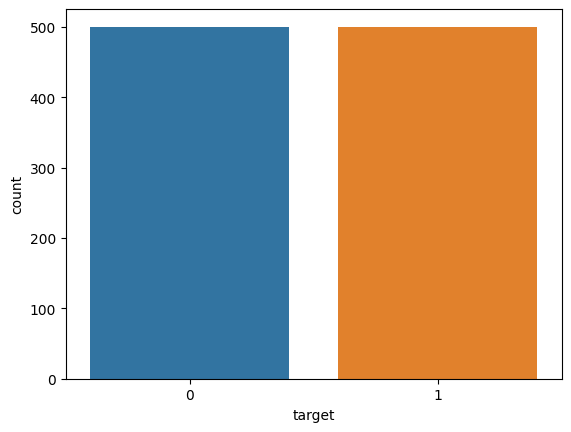

In [12]:
sns.countplot(x='target', data=df)

In [13]:
df[df['target']==1].sample(3)

,text,target
780,I had a pretty satifying experience.,1
891,Their rotating beers on tap is also a highligh...,1
602,They also have the best cheese crisp in town.,1


In [14]:
data = df[['text', 'target']]

In [15]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.sample(5)

,text,target
681,your staff spends more time talking to themsel...,0
548,the desserts were a bit strange.,0
742,i'm not sure how long we stood there but it wa...,0
423,we've tried to like this place but after 10+ t...,0
996,appetite instantly gone.,0


In [16]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
data['text'] = data['text'].apply(lambda x: re_url.sub('', x))

In [17]:
re_letter = re.compile(r"[^a-z\s']")
data['text'] = data['text'].apply(lambda x: re_letter.sub('', x))
data.sample(10)

,text,target
334,i love this place,1
107,the ambience is wonderful and there is music p...,1
445,not to mention the combination of pears almond...,1
625,ambience is perfect,1
207,the worst experience ever,0
388,this is a disgrace,0
96,will be back again,1
938,the meat was pretty dry i had the sliced brisk...,0
255,we had at our table and the service was prett...,1
904,my order was not correct,0


In [18]:
# Wczytujemy model z biblioteki Spacy

nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [19]:
# Wyrzucimy wszystkie stopwords, mozna je wyswietlic poprzez:
# nlp.Defaults.stop_words

def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['text'] = data['text'].apply(remove_stopwords)
data.sample(10)

,text,target
505,recommend place,0
869,feel dining room college cooking course high c...,0
500,taste mom's multigrain pumpkin pancakes pecan ...,1
681,staff spends time talking,0
84,pan cakes raving taste like sugary disaster ta...,0
409,total waste time,0
590,great place fo eat,1
87,food amazing,1
282,waited waited,0
335,great service food,1


In [20]:
# lematyzacja

def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data['text'] = data['text'].progress_apply(lemmatize)
data.sample(10)

100%|██████████| 1000/1000 [00:04<00:00, 241.16it/s]


,text,target
771,great time family dinner sunday night,1
40,shrimp tender moist,1
720,cute quaint simple honest,1
300,good beer drink selection good food selection,1
673,great double cheeseburger,1
950,be not busy know,0
486,toro tartare cavi extraordinary like thinly sl...,1
849,bad day low tolerance rude customer service pe...,0
414,little bad service food suck,0
705,work hospitality industry paradise valley refr...,0


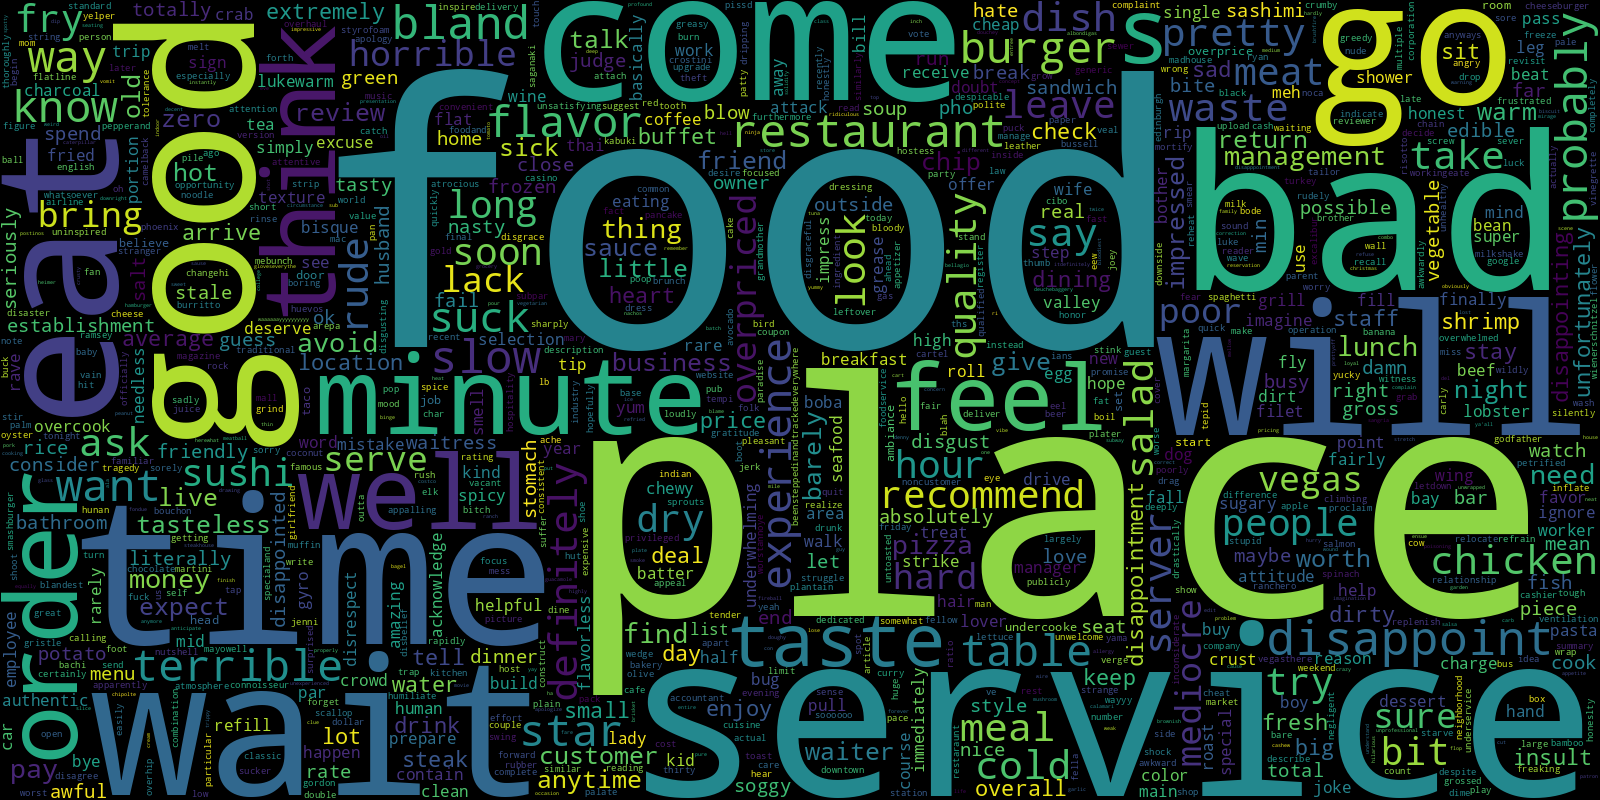

In [21]:
# Zwizulizujemy chmury slow ze zdan nacechowanych negatywnie i pozytywnie

text_neg = ' '.join(data[data['target']==0]['text'])

wc_neg = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

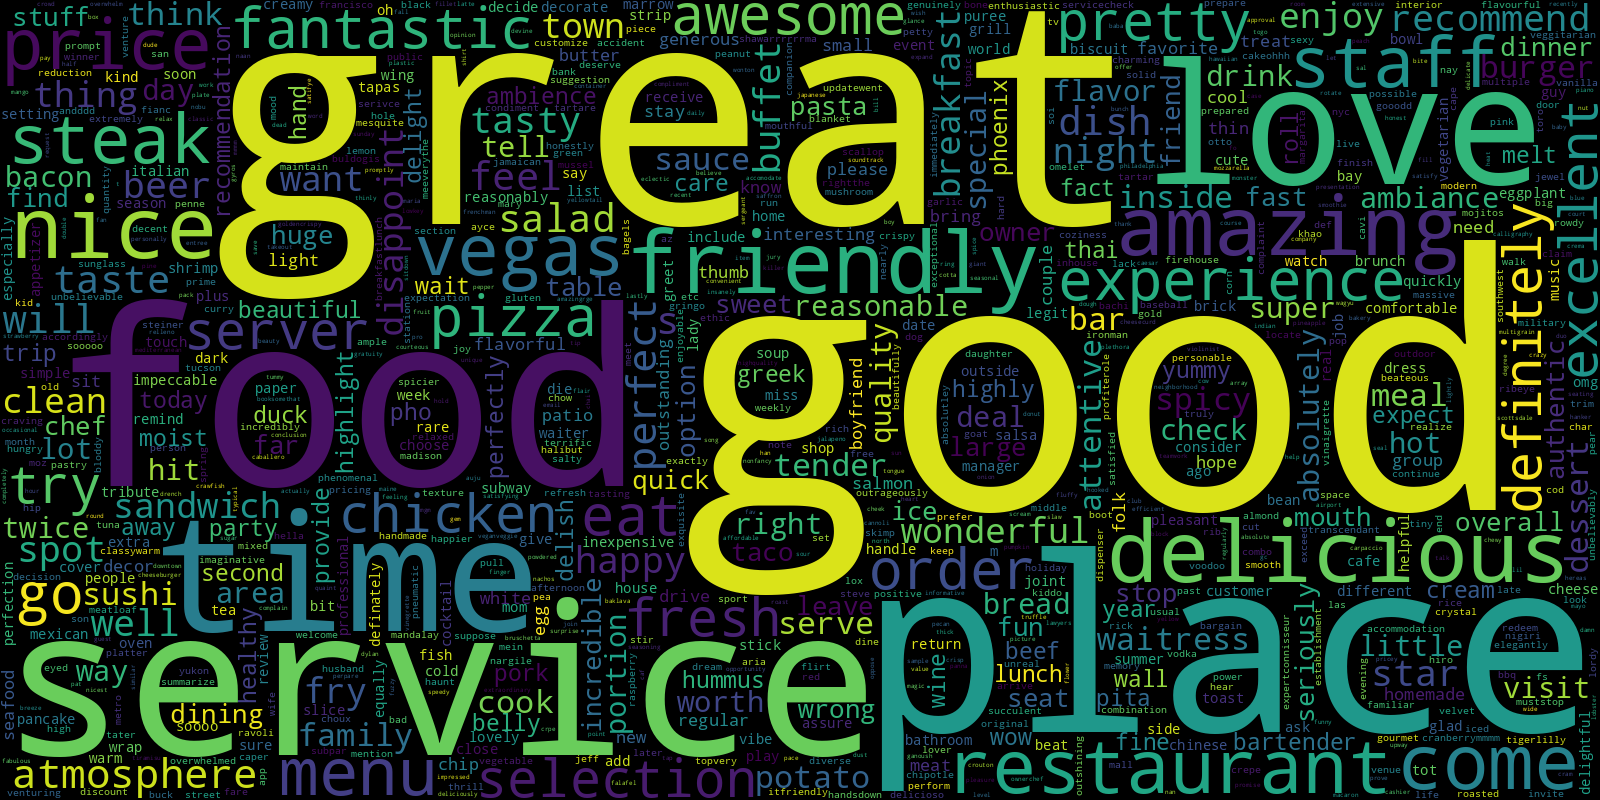

In [22]:
text_pos = ' '.join(data[data['target']==1]['text'])

wc_pos = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

<Axes: xlabel='target', ylabel='count'>

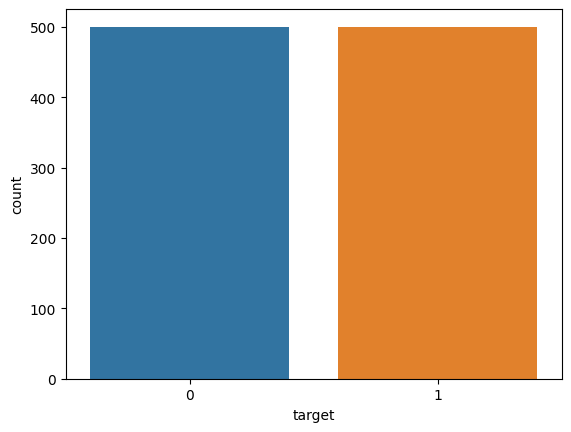

In [23]:
# Dane mamy oczyszzone i przygotowane, ponizej jeszcze raz rozklad klas:

sns.countplot(x='target', data=df)

# Podzial danych

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, stratify=data.target)

In [25]:
for d in (X_train, X_test, y_train, y_test):
  print(d.shape)

(900,)
(100,)
(900,)
(100,)


# Modele analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [26]:
average_sequence_length = df['text'].apply(lambda x: len(x.split())).mean()
int(np.percentile(df['text'].apply(lambda x: len(x.split())), 95))

23

In [27]:
epochs = 5
batch_size = 32

embedding_dim = 50
maxlen = 25

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizacja tekstu
max_words = 10000
tokenizer_lstm = Tokenizer(num_words=max_words)
tokenizer_lstm.fit_on_texts(X_train)

# Zamiana tekstów na sekwencje indeksów
X_train_sequences = tokenizer_lstm.texts_to_sequences(X_train)
X_test_sequences = tokenizer_lstm.texts_to_sequences(X_test)

# Padding sekwencji do najdłuższej sekwencji
X_train_padded = pad_sequences(X_train_sequences, padding='post')
X_test_padded = pad_sequences(X_test_sequences, padding='post', maxlen=X_train_padded.shape[1])

# Kompilacja modelu LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X_train_padded.shape[1]))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
model_lstm.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# Ewaluacja modelu na danych testowych
loss, accuracy = model_lstm.evaluate(X_test_padded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/5
29/29 [==============================] - 11s 249ms/step - loss: 0.6941 - accuracy: 0.5100 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/5
29/29 [==============================] - 2s 66ms/step - loss: 0.6582 - accuracy: 0.6133 - val_loss: 0.6437 - val_accuracy: 0.7100
Epoch 3/5
29/29 [==============================] - 1s 42ms/step - loss: 0.3678 - accuracy: 0.8633 - val_loss: 0.4943 - val_accuracy: 0.7600
Epoch 4/5
29/29 [==============================] - 1s 42ms/step - loss: 0.1769 - accuracy: 0.9389 - val_loss: 0.5296 - val_accuracy: 0.8000
Epoch 5/5
4/4 [==============================] - 0s 5ms/step - loss: 0.7450 - accuracy: 0.7500
Loss: 0.7449510097503662, Accuracy: 0.75


4/4 [==============================] - 0s 6ms/step


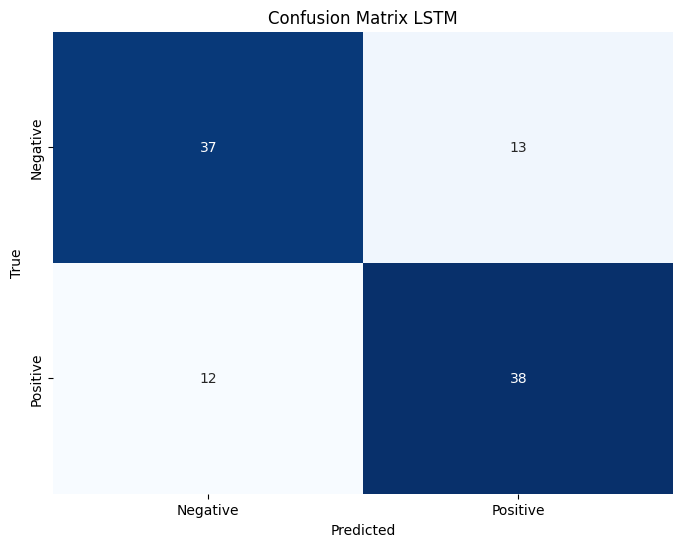

Raport klasyfikacyjny LSTM:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        50
           1       0.75      0.76      0.75        50

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Przewidywanie etykiet dla danych testowych
y_pred_lstm_prob = model_lstm.predict(X_test_padded)
y_pred_lstm_classes = (y_pred_lstm_prob > 0.5).astype(int)

# Macierz pomyłek manualnie
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm_classes)

# Wykres macierzy pomyłek za pomocą biblioteki seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix LSTM')
plt.show()

# Raport klasyfikacyjny
class_report_lstm = classification_report(y_test, y_pred_lstm_classes)
print("Raport klasyfikacyjny LSTM:")
print(class_report_lstm)


In [65]:
text1 = 'i love it'
tokenizer = tokenizer_lstm
model = model_lstm
text_list = [text1]

text_sequence = tokenizer.texts_to_sequences(text_list)
padded_sequence = pad_sequences(text_sequence, padding='post', maxlen=X_train_padded.shape[1])
prediction = model.predict(padded_sequence)
predicted_label = (prediction > 0.5).astype(int)
sentiment_labels = ['Negative', 'Positive']
sentiment = sentiment_labels[predicted_label[0, 0]]

print(sentiment)

1/1 [==============================] - 0s 37ms/step
Positive


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizacja tekstu
max_words = 10000
tokenizer_cnn = Tokenizer(num_words=max_words)
tokenizer_cnn.fit_on_texts(X_train)

# Zamiana tekstów na sekwencje indeksów
X_train_sequences = tokenizer_cnn.texts_to_sequences(X_train)
X_test_sequences = tokenizer_cnn.texts_to_sequences(X_test)

# Padding sekwencji do najdłuższej sekwencji
X_train_padded = pad_sequences(X_train_sequences, padding='post')
X_test_padded = pad_sequences(X_test_sequences, padding='post', maxlen=X_train_padded.shape[1])

# Kompilacja modelu CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X_train_padded.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
model_cnn.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# Ewaluacja modelu na danych testowych
loss, accuracy = model_cnn.evaluate(X_test_padded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/5
29/29 [==============================] - 6s 131ms/step - loss: 0.6910 - accuracy: 0.5122 - val_loss: 0.6829 - val_accuracy: 0.6600
Epoch 2/5
29/29 [==============================] - 3s 87ms/step - loss: 0.6508 - accuracy: 0.7733 - val_loss: 0.6346 - val_accuracy: 0.6800
Epoch 3/5
29/29 [==============================] - 2s 60ms/step - loss: 0.5241 - accuracy: 0.8978 - val_loss: 0.5092 - val_accuracy: 0.7800
Epoch 4/5
29/29 [==============================] - 1s 51ms/step - loss: 0.3221 - accuracy: 0.9178 - val_loss: 0.4261 - val_accuracy: 0.8000
Epoch 5/5
4/4 [==============================] - 0s 5ms/step - loss: 0.4520 - accuracy: 0.7700
Loss: 0.4519506096839905, Accuracy: 0.7699999809265137


4/4 [==============================] - 0s 4ms/step


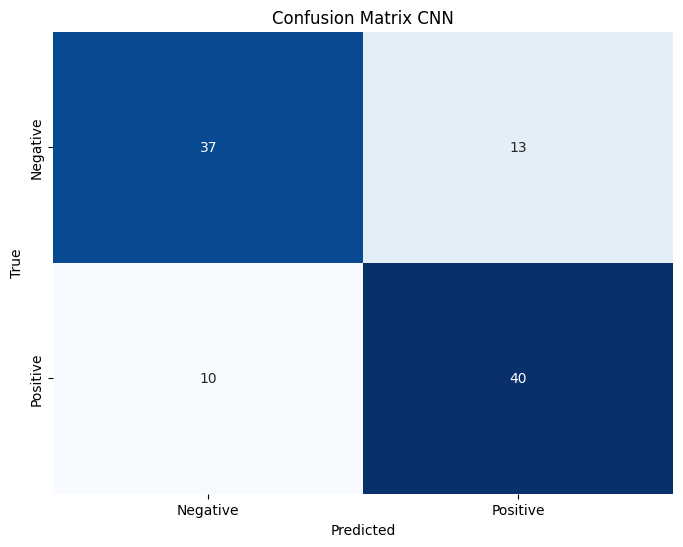

Raport klasyfikacyjny CNN:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        50
           1       0.75      0.80      0.78        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Przewidywanie etykiet dla danych testowych
y_pred_cnn_prob = model_cnn.predict(X_test_padded)
y_pred_cnn_classes = (y_pred_cnn_prob > 0.5).astype(int)

# Macierz pomyłek manualnie
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn_classes)

# Wykres macierzy pomyłek za pomocą biblioteki seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix CNN')
plt.show()

# Raport klasyfikacyjny
class_report_cnn = classification_report(y_test, y_pred_cnn_classes)
print("Raport klasyfikacyjny CNN:")
print(class_report_cnn)


In [70]:
text1='place horrible way overpriced'
tokenizer = tokenizer_cnn
model = model_cnn

text_list = [text1]

text_sequence = tokenizer.texts_to_sequences(text_list)
padded_sequence = pad_sequences(text_sequence, padding='post', maxlen=X_train_padded.shape[1])
prediction = model.predict(padded_sequence)
predicted_label = (prediction > 0.5).astype(int)
sentiment_labels = ['Negative', 'Positive']
sentiment = sentiment_labels[predicted_label[0, 0]]

print(sentiment)

1/1 [==============================] - 0s 28ms/step
Negative


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np

# Ladujemy pre-trained embeddings (np. GloVe)
glove_embeddings_index = {}
embedding_dim = 50  # Wartość ta powinna odpowiadać wymiarowi embeddings, np. dla GloVe 50

with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Tokenizer
max_words = 10000
tokenizer_pretrained_embedding = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer_pretrained_embedding.fit_on_texts(X_train)

# Zamiana tekstow na sekwencje indeksów
X_train_sequences = tokenizer_pretrained_embedding.texts_to_sequences(X_train)
X_test_sequences = tokenizer_pretrained_embedding.texts_to_sequences(X_test)

# Padding sekwencji do najdłuższej sekwencji
X_train_padded = pad_sequences(X_train_sequences, padding='post')
X_test_padded = pad_sequences(X_test_sequences, padding='post', maxlen=X_train_padded.shape[1])

# Przygotowanie macierzy embeddingów
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer_pretrained_embedding.word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Kompilacja modelu z podstawieniem pre-trained embeddings
model_pretrained_embedding = Sequential()
model_pretrained_embedding.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X_train_padded.shape[1], weights=[embedding_matrix], trainable=False))
model_pretrained_embedding.add(LSTM(100))
model_pretrained_embedding.add(Dense(1, activation='sigmoid'))
model_pretrained_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
model_pretrained_embedding.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# Ewaluacja modelu na danych testowych
loss, accuracy = model_pretrained_embedding.evaluate(X_test_padded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/5
29/29 [==============================] - 3s 27ms/step - loss: 0.6699 - accuracy: 0.5767 - val_loss: 0.5669 - val_accuracy: 0.7600
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 0.5567 - accuracy: 0.7233 - val_loss: 0.5143 - val_accuracy: 0.7800
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 0.4980 - accuracy: 0.7678 - val_loss: 0.5231 - val_accuracy: 0.7700
Epoch 4/5
29/29 [==============================] - 0s 9ms/step - loss: 0.4870 - accuracy: 0.7722 - val_loss: 0.4806 - val_accuracy: 0.8100
Epoch 5/5
4/4 [==============================] - 0s 7ms/step - loss: 0.4785 - accuracy: 0.8200
Loss: 0.47852516174316406, Accuracy: 0.8199999928474426


4/4 [==============================] - 0s 5ms/step


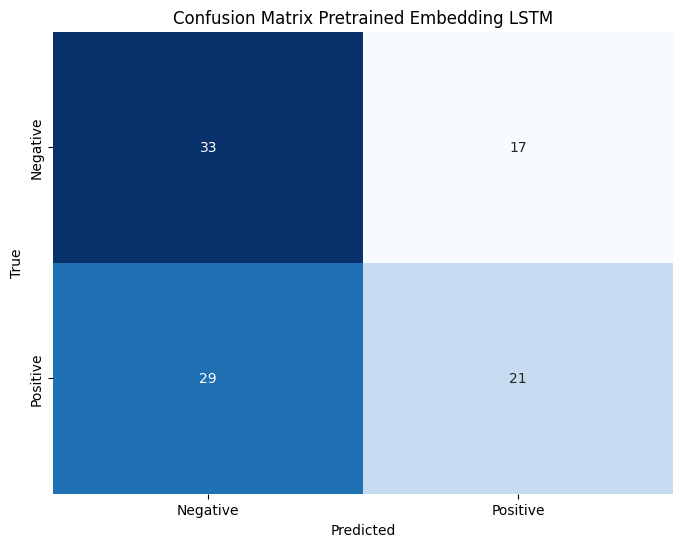

Raport klasyfikacyjny Pretrained Embedding LSTM:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59        50
           1       0.55      0.42      0.48        50

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.53       100
weighted avg       0.54      0.54      0.53       100



In [71]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Przewidywanie etykiet dla danych testowych
y_pred_pretrained_embedding_prob = model_pretrained_embedding.predict(X_test_padded)
y_pred_pretrained_embedding_classes = (y_pred_pretrained_embedding_prob > 0.5).astype(int)

# Macierz pomyłek manualnie
conf_matrix_pretrained_embedding = confusion_matrix(y_test, y_pred_pretrained_embedding_classes)

# Wykres macierzy pomyłek za pomocą biblioteki seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pretrained_embedding, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Pretrained Embedding LSTM')
plt.show()

# Raport klasyfikacyjny
class_report_pretrained_embedding = classification_report(y_test, y_pred_pretrained_embedding_classes)
print("Raport klasyfikacyjny Pretrained Embedding LSTM:")
print(class_report_pretrained_embedding)


In [76]:
text1 = 'come check regularly excellent service'
tokenizer = tokenizer_pretrained_embedding
model = model_pretrained_embedding

text_sequence = tokenizer.texts_to_sequences([text1])
padded_sequence = pad_sequences(text_sequence, padding='post', maxlen=X_train_padded.shape[1])

predictions = model.predict(padded_sequence)
predicted_label = 1 if predictions[0, 0] >= 0.5 else 0

sentiment_labels = ['Negative', 'Positive']
sentiment = sentiment_labels[predicted_label]

print(sentiment)


1/1 [==============================] - 0s 60ms/step
Positive


In [35]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Tokenizacja tekstu za pomocą DistilBERT Tokenizer
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_train_encoded = tokenizer_distilbert(X_train.tolist(), truncation=True, padding=True, return_tensors='tf', max_length=128)
X_test_encoded = tokenizer_distilbert(X_test.tolist(), truncation=True, padding=True, return_tensors='tf', max_length=128)

# Przygotowanie danych jako tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: X_train_encoded[key] for key in X_train_encoded},
    y_train
)).shuffle(100).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {key: X_test_encoded[key] for key in X_test_encoded},
    y_test
)).batch(batch_size)

# Załadowanie pre-trained DistilBERT model
model_distilbert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Kompilacja modelu DistilBERT
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_distilbert.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Trenowanie modelu DistilBERT
model_distilbert.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Ewaluacja modelu DistilBERT na danych testowych
predictions = model_distilbert.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1)
accuracy = accuracy_score(y_test, predicted_labels.numpy())
print(f'Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
29/29 [==============================] - 36s 232ms/step - loss: 0.6561 - accuracy: 0.6433 - val_loss: 0.5607 - val_accuracy: 0.6900
Epoch 2/5
29/29 [==============================] - 5s 167ms/step - loss: 0.4570 - accuracy: 0.8256 - val_loss: 0.4373 - val_accuracy: 0.8200
Epoch 3/5
29/29 [==============================] - 4s 125ms/step - loss: 0.2943 - accuracy: 0.8911 - val_loss: 0.4205 - val_accuracy: 0.8100
Epoch 4/5
29/29 [==============================] - 3s 113ms/step - loss: 0.1822 - accuracy: 0.9344 - val_loss: 0.5023 - val_accuracy: 0.7900
Epoch 5/5
4/4 [==============================] - 2s 34ms/step
Accuracy: 0.8


4/4 [==============================] - 0s 55ms/step
Accuracy: 0.8


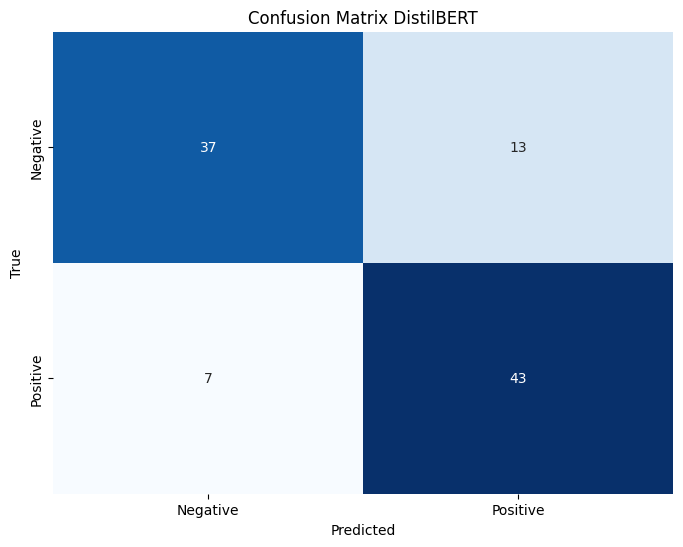

Raport klasyfikacyjny DistilBERT:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        50
           1       0.77      0.86      0.81        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Przewidywanie etykiet dla danych testowych
predictions_distilbert = model_distilbert.predict(test_dataset)
predicted_labels_distilbert = tf.argmax(predictions_distilbert.logits, axis=1)
accuracy_distilbert = accuracy_score(y_test, predicted_labels_distilbert.numpy())
print(f'Accuracy: {accuracy_distilbert}')

# Macierz pomyłek manualnie
conf_matrix_distilbert = confusion_matrix(y_test, predicted_labels_distilbert)

# Wykres macierzy pomyłek za pomocą biblioteki seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_distilbert, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix DistilBERT')
plt.show()

# Raport klasyfikacyjny
class_report_distilbert = classification_report(y_test, predicted_labels_distilbert)
print("Raport klasyfikacyjny DistilBERT:")
print(class_report_distilbert)


In [78]:
text1 = 'give try eat crust tooth sore'
tokenizer = tokenizer_distilbert
model = model_distilbert

text_encoded = tokenizer_distilbert(text1, truncation=True, padding=True, return_tensors='tf', max_length=128)
input_ids = np.array(text_encoded['input_ids'])
attention_mask = np.array(text_encoded['attention_mask'])
text_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': input_ids, 'attention_mask': attention_mask}
))
predictions = model.predict(text_dataset)
predicted_label = tf.argmax(predictions.logits, axis=1)
sentiment_labels = ['Negative', 'Positive']
sentiment = sentiment_labels[predicted_label[0]]

print(sentiment)

1/1 [==============================] - 0s 65ms/step
Negative


## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [66]:
def predict_sentiment(text, model_name, max_length=25):
  '''
  Funkcja dostaje tekst i jeden z 4 modeli do wyboru i zwraca informacje czy text nacechowany jest negatywnie czy pozytywnie
  text to ocena restauracji w jezyku angielskim
  model przyjmuje wartosci: 'lstm', 'cnn', 'pretrained_embedding', 'distilbert'
  '''
  if model_name in ('lstm'):
    tokenizer = tokenizer_lstm
    model = model_lstm
    text_list = [text]
    text_sequence = tokenizer.texts_to_sequences(text_list)
    padded_sequence = pad_sequences(text_sequence, padding='post', maxlen=X_train_padded.shape[1])
    prediction = model.predict(padded_sequence)
    predicted_label = (prediction > 0.5).astype(int)
    sentiment_labels = ['Negative', 'Positive']
    sentiment = sentiment_labels[predicted_label[0, 0]]

  if model_name in ('cnn'):
    tokenizer = tokenizer_cnn
    model = model_cnn
    text_list = [text]
    text_sequence = tokenizer.texts_to_sequences(text_list)
    padded_sequence = pad_sequences(text_sequence, padding='post', maxlen=X_train_padded.shape[1])
    prediction = model.predict(padded_sequence)
    predicted_label = (prediction > 0.5).astype(int)
    sentiment_labels = ['Negative', 'Positive']
    sentiment = sentiment_labels[predicted_label[0, 0]]

  if model_name in ('pretrained_embedding'):
    tokenizer = tokenizer_pretrained_embedding
    model = model_pretrained_embedding
    text_sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(text_sequence, padding='post', maxlen=X_train_padded.shape[1])
    predictions = model.predict(padded_sequence)
    predicted_label = 1 if predictions[0, 0] >= 0.5 else 0
    sentiment_labels = ['Negative', 'Positive']
    sentiment = sentiment_labels[predicted_label]

  if model_name in ('distilbert'):
    tokenizer = tokenizer_distilbert
    model = model_distilbert
    text_encoded = tokenizer_distilbert(text, truncation=True, padding=True, return_tensors='tf', max_length=128)
    input_ids = np.array(text_encoded['input_ids'])
    attention_mask = np.array(text_encoded['attention_mask'])
    text_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_mask}
    ))
    predictions = model.predict(text_dataset)
    predicted_label = tf.argmax(predictions.logits, axis=1)
    sentiment_labels = ['Negative', 'Positive']
    sentiment = sentiment_labels[predicted_label[0]]


  print('--------------------------------------------------------')
  return print(f' Sentence: "{text}" \n Model: "{model_name}" \n Predicted class: "{sentiment}"')

In [67]:
data.smple(5)

,text,target
717,tonight elk filet specialand suck,0
702,go meal awesome,1
50,order duck rare pink tender inside nice char o...,1
964,del taco pretty nasty avoid possible,0
373,customize order way you would like usual eggpl...,1


In [68]:
text_test_list = X_test.sample(3)
text_test_list

364            server great job handle large rowdy table
555                                 know like restaurant
985    problem charge sandwich big subway sub offer w...
Name: text, dtype: object

In [79]:
for text in text_test_list:
  for modelname in ['lstm', 'cnn', 'pretrained_embedding', 'distilbert']:
     predict_sentiment(text, modelname)

1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------
 Sentence: "server great job handle large rowdy table" 
 Model: "lstm" 
 Predicted class: "Positive"
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------
 Sentence: "server great job handle large rowdy table" 
 Model: "cnn" 
 Predicted class: "Positive"
1/1 [==============================] - 0s 110ms/step
--------------------------------------------------------
 Sentence: "server great job handle large rowdy table" 
 Model: "pretrained_embedding" 
 Predicted class: "Positive"
1/1 [==============================] - 0s 52ms/step
--------------------------------------------------------
 Sentence: "server great job handle large rowdy table" 
 Model: "distilbert" 
 Predicted class: "Positive"
1/1 [==============================] - 0s 56ms/step
--------------------------------------------------------
 Sentence: "know like restaur